# Cattle Detection Dataset Analysis - Phase 1.1

This notebook performs initial analysis of the cattle detection datasets downloaded from Roboflow.

## Objectives
1. Explore the structure of downloaded datasets
2. Analyze image properties (dimensions, formats, etc.)
3. Examine annotation quality and distribution
4. Visualize sample images with bounding boxes
5. Prepare data statistics for model training decisions

In [14]:
# Import required libraries
import os
import sys
import json
import yaml
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings('ignore')

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

print("Libraries imported successfully!")
print(f"Current working directory: {os.getcwd()}")

Libraries imported successfully!
Current working directory: /home/nicolas-ubuntu/Desktop/repos/cattle/cattle-recognition/notebooks


In [15]:
# Project paths
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
DATA_DIR = PROJECT_ROOT / "data" / "detection"

print(f"Project root: {PROJECT_ROOT}")
print(f"Data directory: {DATA_DIR}")
print(f"Data directory exists: {DATA_DIR.exists()}")

# List all downloaded datasets
if DATA_DIR.exists():
    datasets = [d for d in DATA_DIR.iterdir() if d.is_dir()]
    print(f"\nFound {len(datasets)} datasets:")
    for dataset in datasets:
        print(f"  - {dataset.name}")
else:
    print("\n❌ Data directory not found. Please run the download script first.")
    datasets = []

Project root: /home/nicolas-ubuntu/Desktop/repos/cattle/cattle-recognition
Data directory: /home/nicolas-ubuntu/Desktop/repos/cattle/cattle-recognition/data/detection
Data directory exists: True

Found 4 datasets:
  - cattle-detection-v2
  - cow-counting-v3
  - cattle-detection-v3
  - cattle-detection-v1


## Dataset Structure Analysis

In [16]:
def analyze_dataset_structure(dataset_path):
    """Analyze the structure of a YOLO dataset."""
    dataset_info = {
        'name': dataset_path.name,
        'path': str(dataset_path),
        'splits': {},
        'total_images': 0,
        'total_annotations': 0
    }
    
    # Look for YOLO dataset structure (train, val, test folders)
    for split in ['train', 'valid', 'test']:
        split_path = dataset_path / split
        if split_path.exists():
            images_path = split_path / 'images'
            labels_path = split_path / 'labels'
            
            if images_path.exists() and labels_path.exists():
                image_files = list(images_path.glob('*.[jp][pn]g')) + list(images_path.glob('*.jpeg'))
                label_files = list(labels_path.glob('*.txt'))
                
                dataset_info['splits'][split] = {
                    'images': len(image_files),
                    'labels': len(label_files),
                    'images_path': str(images_path),
                    'labels_path': str(labels_path)
                }
                
                dataset_info['total_images'] += len(image_files)
                dataset_info['total_annotations'] += len(label_files)
    
    # Look for data.yaml file
    yaml_file = dataset_path / 'data.yaml'
    if yaml_file.exists():
        try:
            with open(yaml_file, 'r') as f:
                yaml_data = yaml.safe_load(f)
            dataset_info['yaml_info'] = yaml_data
        except Exception as e:
            print(f"Warning: Could not read {yaml_file}: {e}")
    
    return dataset_info

# Analyze all datasets
dataset_analyses = []
for dataset_path in datasets:
    analysis = analyze_dataset_structure(dataset_path)
    dataset_analyses.append(analysis)
    
    print(f"\n{'='*50}")
    print(f"Dataset: {analysis['name']}")
    print(f"{'='*50}")
    print(f"Total images: {analysis['total_images']}")
    print(f"Total annotations: {analysis['total_annotations']}")
    
    for split, info in analysis['splits'].items():
        print(f"  {split.capitalize()}: {info['images']} images, {info['labels']} labels")
    
    if 'yaml_info' in analysis:
        yaml_info = analysis['yaml_info']
        if 'names' in yaml_info:
            print(f"  Classes: {yaml_info['names']}")
        if 'nc' in yaml_info:
            print(f"  Number of classes: {yaml_info['nc']}")


Dataset: cattle-detection-v2
Total images: 991
Total annotations: 991
  Train: 693 images, 693 labels
  Valid: 199 images, 199 labels
  Test: 99 images, 99 labels
  Classes: ['cow']
  Number of classes: 1

Dataset: cow-counting-v3
Total images: 3371
Total annotations: 3371
  Train: 2381 images, 2381 labels
  Valid: 660 images, 660 labels
  Test: 330 images, 330 labels
  Classes: ['cattle']
  Number of classes: 1

Dataset: cattle-detection-v3
Total images: 991
Total annotations: 991
  Train: 693 images, 693 labels
  Valid: 199 images, 199 labels
  Test: 99 images, 99 labels
  Classes: ['cow']
  Number of classes: 1

Dataset: cattle-detection-v1
Total images: 2368
Total annotations: 2368
  Train: 2070 images, 2070 labels
  Valid: 199 images, 199 labels
  Test: 99 images, 99 labels
  Classes: ['cow']
  Number of classes: 1


## Image Properties Analysis

In [17]:
def analyze_image_properties(dataset_path, split='train', max_samples=100):
    """Analyze image properties like dimensions, file sizes, etc."""
    images_path = dataset_path / split / 'images'
    
    if not images_path.exists():
        return None
    
    image_files = list(images_path.glob('*.[jp][pn]g')) + list(images_path.glob('*.jpeg'))
    
    # Sample images if there are too many
    if len(image_files) > max_samples:
        image_files = np.random.choice(image_files, max_samples, replace=False)
    
    properties = {
        'widths': [],
        'heights': [],
        'aspect_ratios': [],
        'file_sizes': [],
        'formats': []
    }
    
    for img_file in image_files:
        try:
            # Get file size
            file_size = img_file.stat().st_size / (1024 * 1024)  # MB
            properties['file_sizes'].append(file_size)
            
            # Get image dimensions
            with Image.open(img_file) as img:
                width, height = img.size
                properties['widths'].append(width)
                properties['heights'].append(height)
                properties['aspect_ratios'].append(width / height)
                properties['formats'].append(img.format)
                
        except Exception as e:
            print(f"Error processing {img_file}: {e}")
            continue
    
    return properties

# Analyze image properties for all datasets
print("Analyzing image properties...")
image_properties = {}

for dataset_path in datasets:
    dataset_name = dataset_path.name
    props = analyze_image_properties(dataset_path)
    
    if props:
        image_properties[dataset_name] = props
        
        print(f"\n{dataset_name}:")
        print(f"  Sample size: {len(props['widths'])} images")
        print(f"  Width range: {min(props['widths'])} - {max(props['widths'])} px")
        print(f"  Height range: {min(props['heights'])} - {max(props['heights'])} px")
        print(f"  Average file size: {np.mean(props['file_sizes']):.2f} MB")
        print(f"  Formats: {set(props['formats'])}")
    else:
        print(f"\n{dataset_name}: No images found in train split")

Analyzing image properties...

cattle-detection-v2:
  Sample size: 100 images
  Width range: 640 - 640 px
  Height range: 640 - 640 px
  Average file size: 0.08 MB
  Formats: {'JPEG'}

cow-counting-v3:
  Sample size: 100 images
  Width range: 183 - 1920 px
  Height range: 168 - 1099 px
  Average file size: 0.06 MB
  Formats: {'JPEG'}

cattle-detection-v3:
  Sample size: 100 images
  Width range: 1920 - 1920 px
  Height range: 1080 - 1080 px
  Average file size: 0.37 MB
  Formats: {'JPEG'}

cattle-detection-v1:
  Sample size: 100 images
  Width range: 640 - 640 px
  Height range: 640 - 640 px
  Average file size: 0.08 MB
  Formats: {'JPEG'}


## Annotation Analysis

In [18]:
def analyze_annotations(dataset_path, split='train', max_samples=100):
    """Analyze YOLO format annotations."""
    labels_path = dataset_path / split / 'labels'
    
    if not labels_path.exists():
        return None
    
    label_files = list(labels_path.glob('*.txt'))
    
    if len(label_files) > max_samples:
        label_files = np.random.choice(label_files, max_samples, replace=False)
    
    annotation_stats = {
        'objects_per_image': [],
        'class_distribution': defaultdict(int),
        'bbox_widths': [],
        'bbox_heights': [],
        'bbox_areas': [],
        'bbox_centers_x': [],
        'bbox_centers_y': []
    }
    
    for label_file in label_files:
        try:
            with open(label_file, 'r') as f:
                lines = f.readlines()
            
            objects_in_image = len(lines)
            annotation_stats['objects_per_image'].append(objects_in_image)
            
            for line in lines:
                parts = line.strip().split()
                if len(parts) >= 5:
                    class_id = int(parts[0])
                    x_center = float(parts[1])
                    y_center = float(parts[2])
                    width = float(parts[3])
                    height = float(parts[4])
                    
                    annotation_stats['class_distribution'][class_id] += 1
                    annotation_stats['bbox_widths'].append(width)
                    annotation_stats['bbox_heights'].append(height)
                    annotation_stats['bbox_areas'].append(width * height)
                    annotation_stats['bbox_centers_x'].append(x_center)
                    annotation_stats['bbox_centers_y'].append(y_center)
                    
        except Exception as e:
            print(f"Error processing {label_file}: {e}")
            continue
    
    return annotation_stats

# Analyze annotations for all datasets
print("Analyzing annotations...")
annotation_stats = {}

for dataset_path in datasets:
    dataset_name = dataset_path.name
    stats = analyze_annotations(dataset_path)
    
    if stats:
        annotation_stats[dataset_name] = stats
        
        print(f"\n{dataset_name}:")
        print(f"  Sample size: {len(stats['objects_per_image'])} images")
        print(f"  Objects per image: {np.mean(stats['objects_per_image']):.1f} ± {np.std(stats['objects_per_image']):.1f}")
        print(f"  Total objects: {sum(stats['objects_per_image'])}")
        print(f"  Class distribution: {dict(stats['class_distribution'])}")
        print(f"  Average bbox area: {np.mean(stats['bbox_areas']):.3f}")
    else:
        print(f"\n{dataset_name}: No annotations found in train split")

Analyzing annotations...

cattle-detection-v2:
  Sample size: 100 images
  Objects per image: 19.0 ± 16.3
  Total objects: 1897
  Class distribution: {0: 1897}
  Average bbox area: 0.001

cow-counting-v3:
  Sample size: 100 images
  Objects per image: 3.4 ± 6.1
  Total objects: 344
  Class distribution: {0: 344}
  Average bbox area: 0.127

cattle-detection-v3:
  Sample size: 100 images
  Objects per image: 15.7 ± 12.5
  Total objects: 1566
  Class distribution: {0: 1566}
  Average bbox area: 0.001

cattle-detection-v1:
  Sample size: 100 images
  Objects per image: 19.1 ± 21.4
  Total objects: 1910
  Class distribution: {0: 1910}
  Average bbox area: 0.001


## Data Visualization

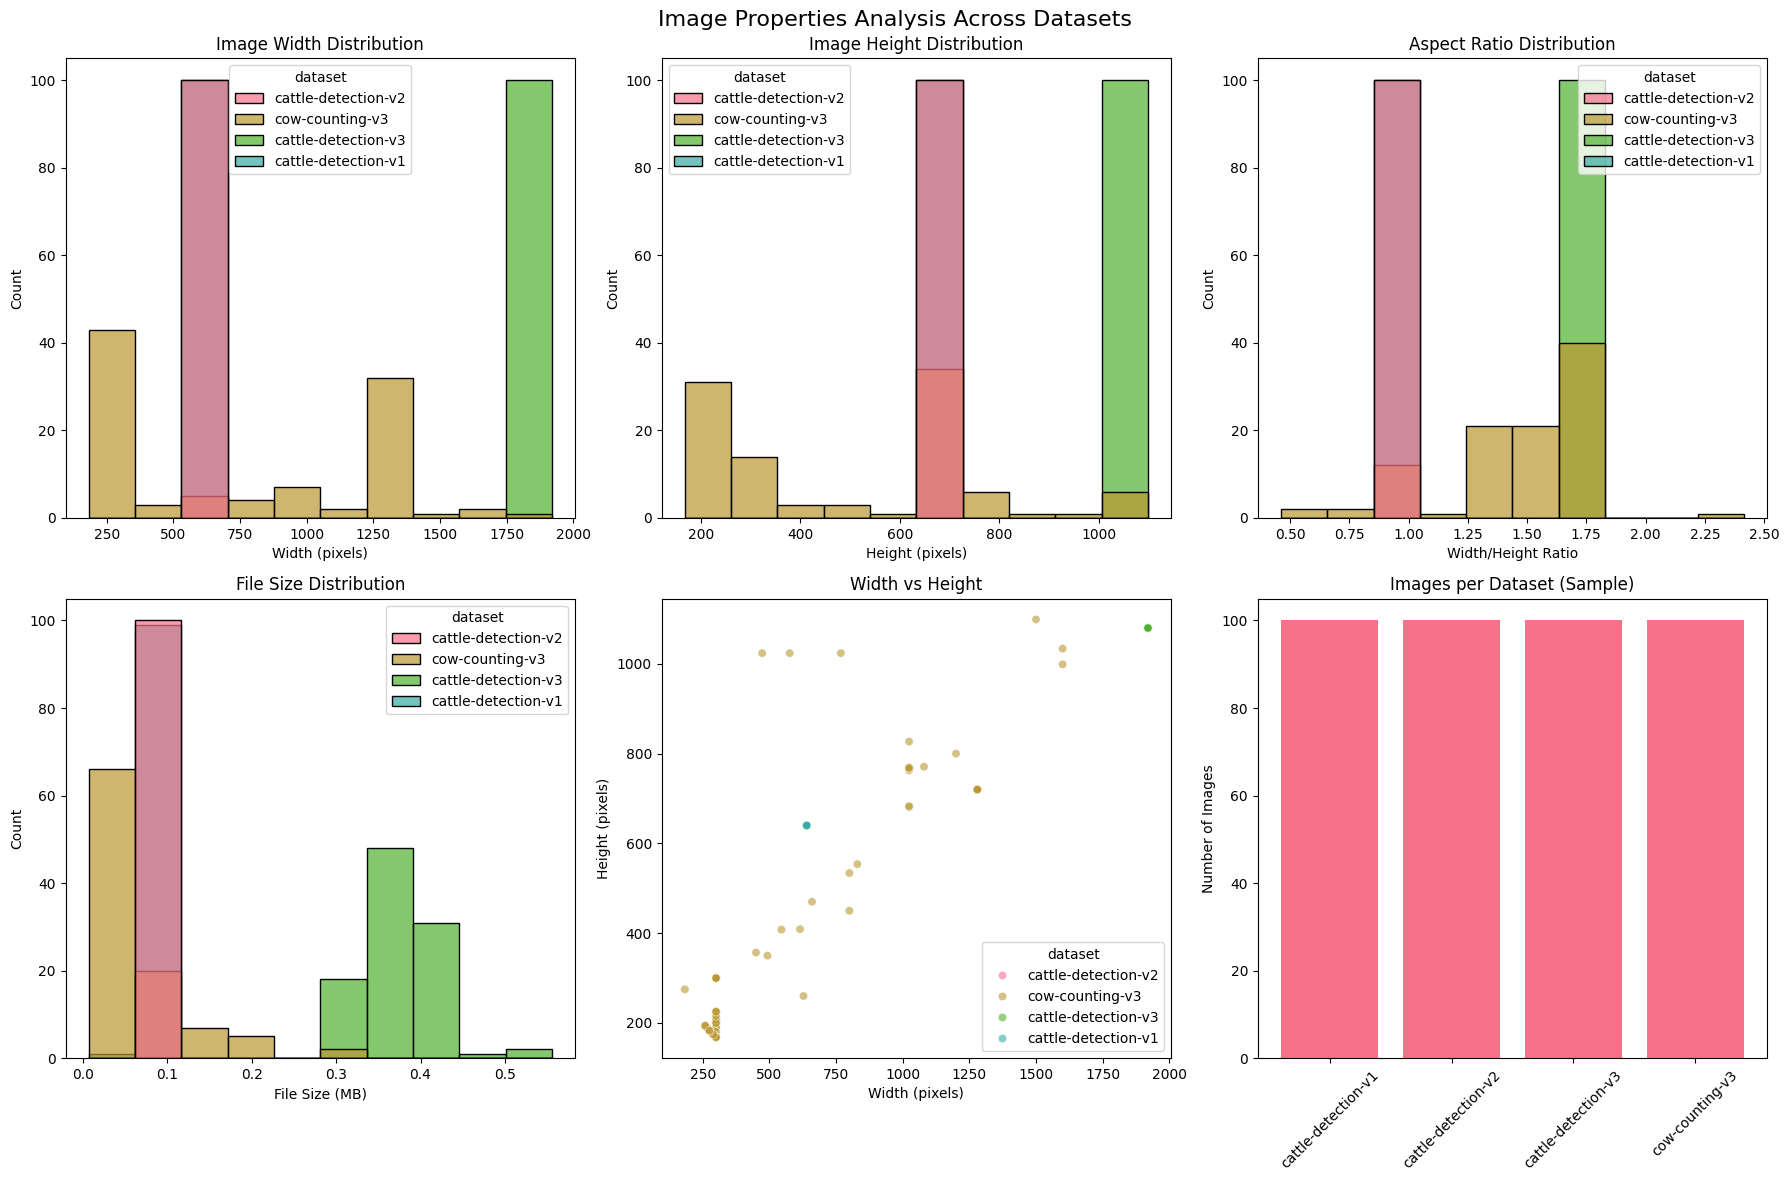

In [19]:
# Create comprehensive visualizations
if image_properties:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Image Properties Analysis Across Datasets', fontsize=16)
    
    # Collect data for plotting
    all_widths = []
    all_heights = []
    all_aspect_ratios = []
    all_file_sizes = []
    dataset_labels = []
    
    for dataset_name, props in image_properties.items():
        all_widths.extend(props['widths'])
        all_heights.extend(props['heights'])
        all_aspect_ratios.extend(props['aspect_ratios'])
        all_file_sizes.extend(props['file_sizes'])
        dataset_labels.extend([dataset_name] * len(props['widths']))
    
    # Create DataFrame for easier plotting
    df = pd.DataFrame({
        'width': all_widths,
        'height': all_heights,
        'aspect_ratio': all_aspect_ratios,
        'file_size': all_file_sizes,
        'dataset': dataset_labels
    })
    
    # Plot 1: Width distribution
    sns.histplot(data=df, x='width', hue='dataset', ax=axes[0,0], alpha=0.7)
    axes[0,0].set_title('Image Width Distribution')
    axes[0,0].set_xlabel('Width (pixels)')
    
    # Plot 2: Height distribution
    sns.histplot(data=df, x='height', hue='dataset', ax=axes[0,1], alpha=0.7)
    axes[0,1].set_title('Image Height Distribution')
    axes[0,1].set_xlabel('Height (pixels)')
    
    # Plot 3: Aspect ratio distribution
    sns.histplot(data=df, x='aspect_ratio', hue='dataset', ax=axes[0,2], alpha=0.7)
    axes[0,2].set_title('Aspect Ratio Distribution')
    axes[0,2].set_xlabel('Width/Height Ratio')
    
    # Plot 4: File size distribution
    sns.histplot(data=df, x='file_size', hue='dataset', ax=axes[1,0], alpha=0.7)
    axes[1,0].set_title('File Size Distribution')
    axes[1,0].set_xlabel('File Size (MB)')
    
    # Plot 5: Width vs Height scatter
    sns.scatterplot(data=df, x='width', y='height', hue='dataset', ax=axes[1,1], alpha=0.6)
    axes[1,1].set_title('Width vs Height')
    axes[1,1].set_xlabel('Width (pixels)')
    axes[1,1].set_ylabel('Height (pixels)')
    
    # Plot 6: Dataset summary
    dataset_summary = df.groupby('dataset').agg({
        'width': 'count',
        'file_size': 'mean'
    }).reset_index()
    dataset_summary.columns = ['dataset', 'image_count', 'avg_file_size']
    
    bars = axes[1,2].bar(dataset_summary['dataset'], dataset_summary['image_count'])
    axes[1,2].set_title('Images per Dataset (Sample)')
    axes[1,2].set_ylabel('Number of Images')
    axes[1,2].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
else:
    print("No image properties data to visualize.")

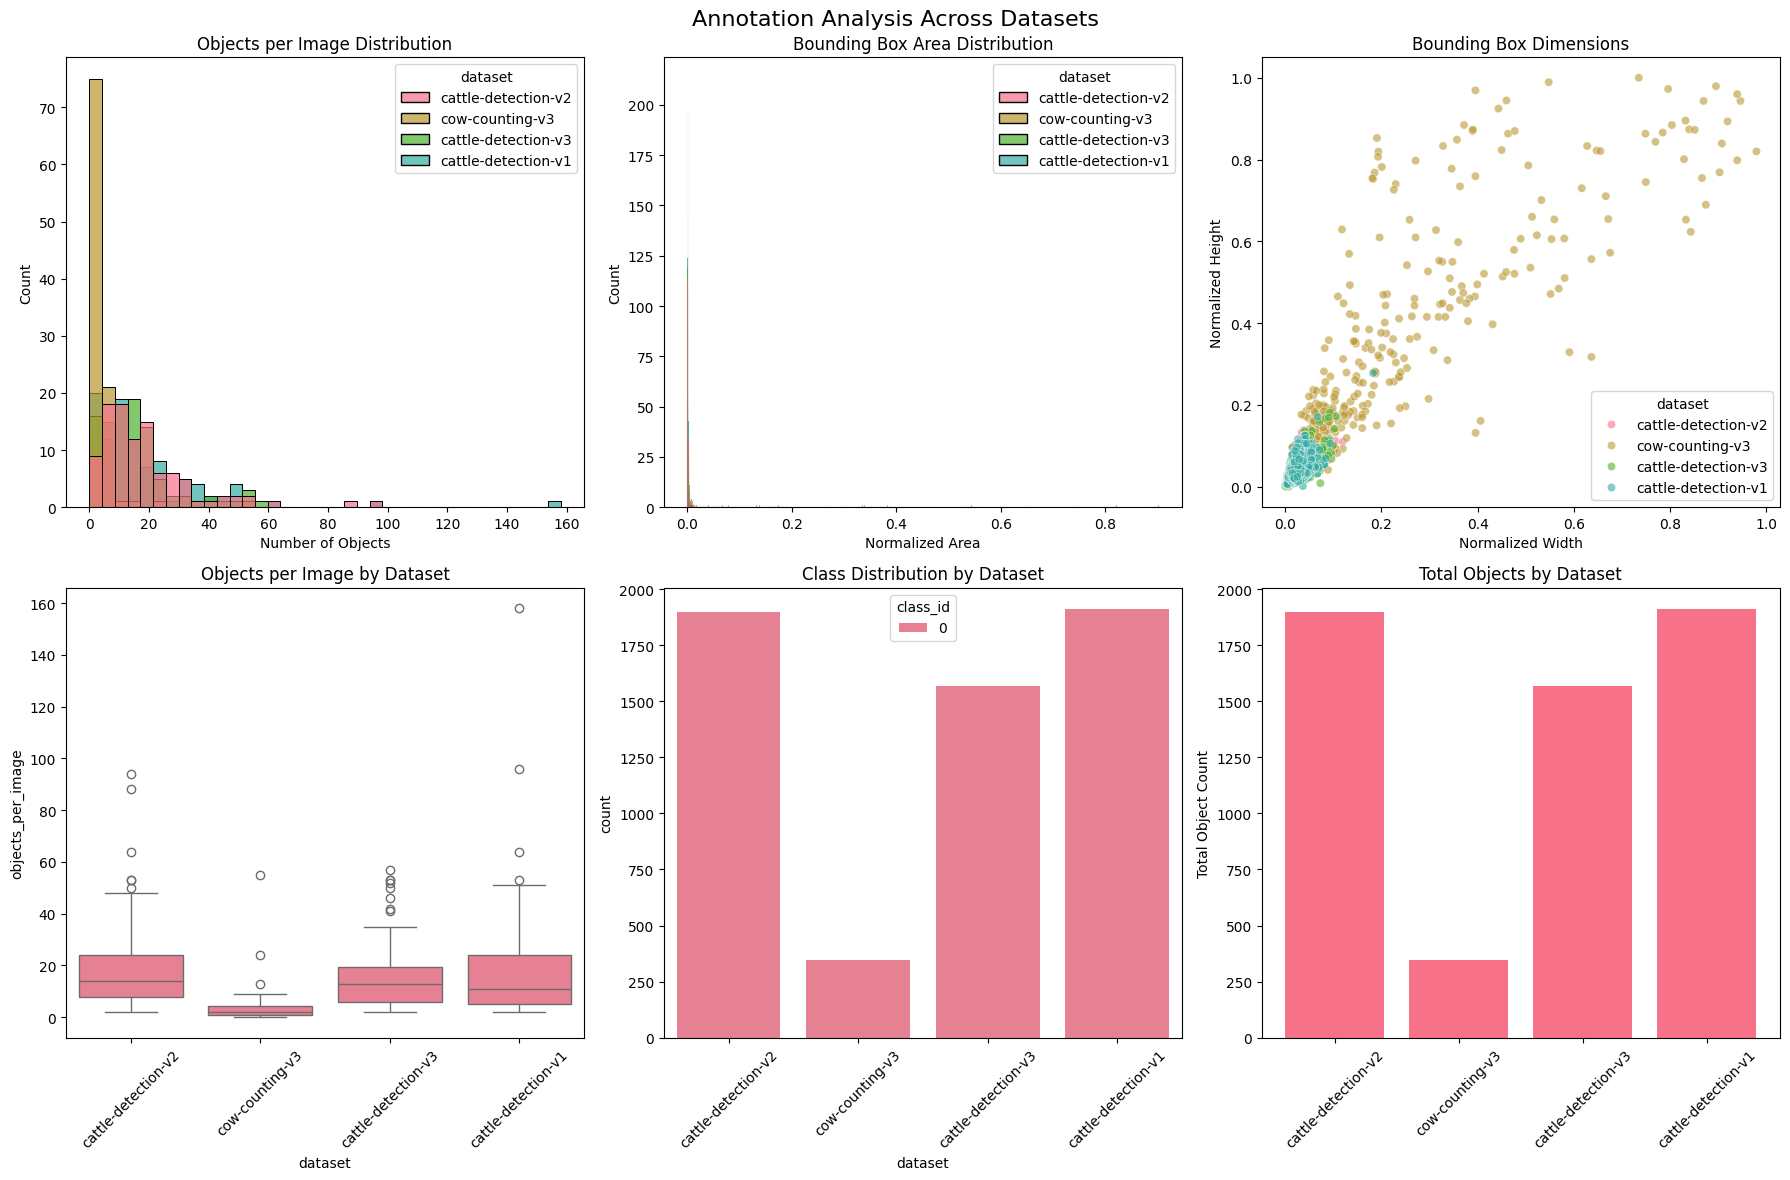

In [23]:
# Annotation visualization
if annotation_stats:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Annotation Analysis Across Datasets', fontsize=16)
    
    # Collect annotation data
    all_objects_per_image = []
    all_bbox_areas = []
    all_bbox_widths = []
    all_bbox_heights = []
    annotation_dataset_labels = []
    
    for dataset_name, stats in annotation_stats.items():
        all_objects_per_image.extend(stats['objects_per_image'])
        all_bbox_areas.extend(stats['bbox_areas'])
        all_bbox_widths.extend(stats['bbox_widths'])
        all_bbox_heights.extend(stats['bbox_heights'])
        annotation_dataset_labels.extend([dataset_name] * len(stats['objects_per_image']))
    
    # Create DataFrame
    ann_df = pd.DataFrame({
        'objects_per_image': all_objects_per_image,
        'dataset': annotation_dataset_labels
    })
    
    bbox_df = pd.DataFrame({
        'bbox_area': all_bbox_areas,
        'bbox_width': all_bbox_widths,
        'bbox_height': all_bbox_heights,
        'dataset': [label for dataset_name, stats in annotation_stats.items() 
                   for label in [dataset_name] * len(stats['bbox_areas'])]
    })
    
    # Plot 1: Objects per image
    sns.histplot(data=ann_df, x='objects_per_image', hue='dataset', ax=axes[0,0], alpha=0.7)
    axes[0,0].set_title('Objects per Image Distribution')
    axes[0,0].set_xlabel('Number of Objects')
    
    # Plot 2: Bounding box areas
    sns.histplot(data=bbox_df, x='bbox_area', hue='dataset', ax=axes[0,1], alpha=0.7)
    axes[0,1].set_title('Bounding Box Area Distribution')
    axes[0,1].set_xlabel('Normalized Area')
    
    # Plot 3: Bounding box width vs height
    sns.scatterplot(data=bbox_df, x='bbox_width', y='bbox_height', hue='dataset', ax=axes[0,2], alpha=0.6)
    axes[0,2].set_title('Bounding Box Dimensions')
    axes[0,2].set_xlabel('Normalized Width')
    axes[0,2].set_ylabel('Normalized Height')
    
    # Plot 4: Objects per image by dataset
    sns.boxplot(data=ann_df, x='dataset', y='objects_per_image', ax=axes[1,0])
    axes[1,0].set_title('Objects per Image by Dataset')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # Plot 5: Class distribution summary
    class_dist_data = []
    for dataset_name, stats in annotation_stats.items():
        for class_id, count in stats['class_distribution'].items():
            class_dist_data.append({'dataset': dataset_name, 'class_id': class_id, 'count': count})
    
    if class_dist_data:
        class_df = pd.DataFrame(class_dist_data)
        sns.barplot(data=class_df, x='dataset', y='count', hue='class_id', ax=axes[1,1])
        axes[1,1].set_title('Class Distribution by Dataset')
        axes[1,1].tick_params(axis='x', rotation=45)
    
    # Plot 6: Total annotations summary
    total_annotations = []
    for dataset_name, stats in annotation_stats.items():
        total_annotations.append({
            'dataset': dataset_name,
            'total_objects': sum(stats['objects_per_image'])
        })
    
    if total_annotations:
        total_df = pd.DataFrame(total_annotations)
        bars = axes[1,2].bar(total_df['dataset'], total_df['total_objects'])
        axes[1,2].set_title('Total Objects by Dataset')
        axes[1,2].set_ylabel('Total Object Count')
        axes[1,2].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
else:
    print("No annotation data to visualize.")

## Sample Image Visualization

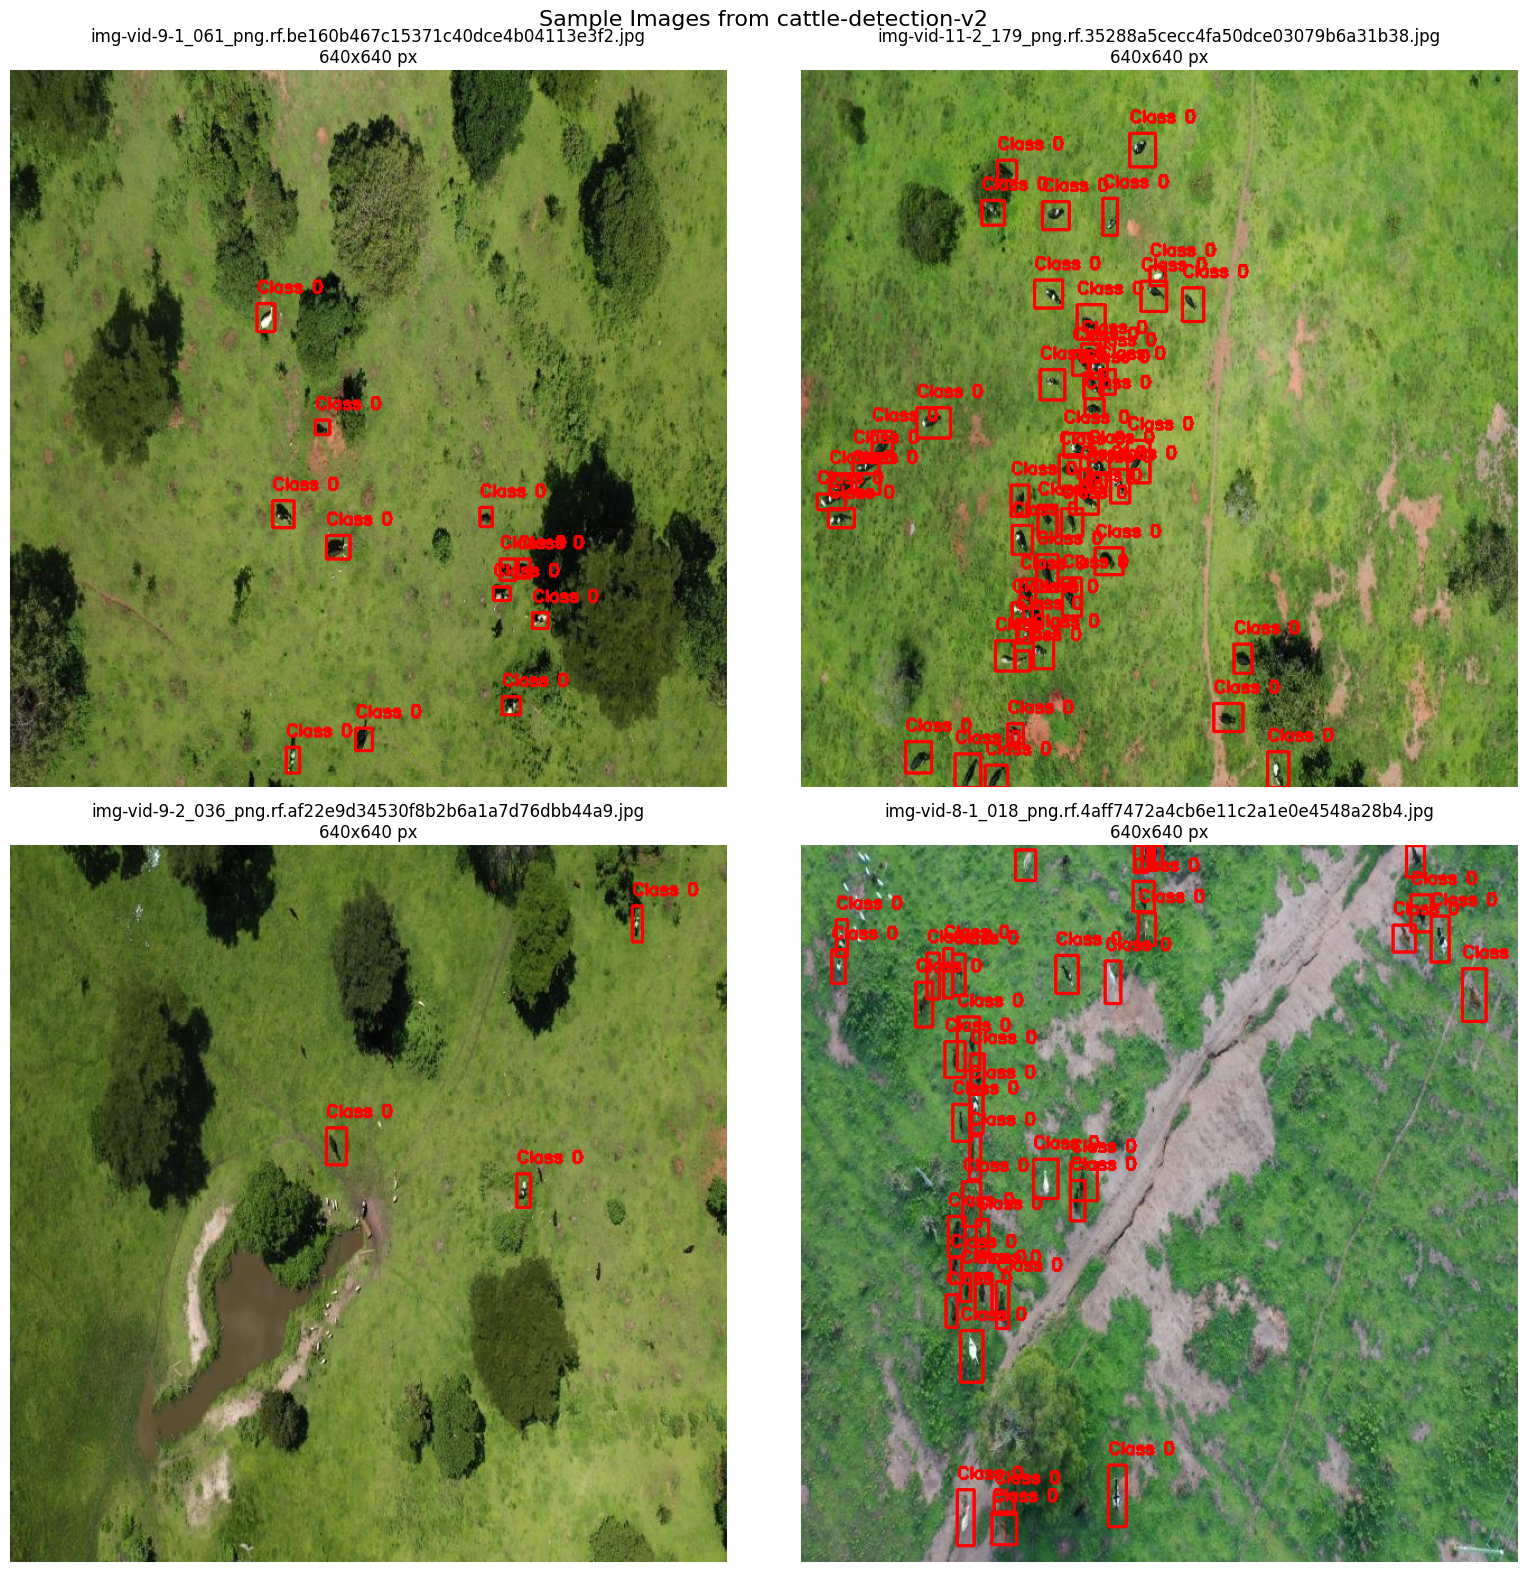

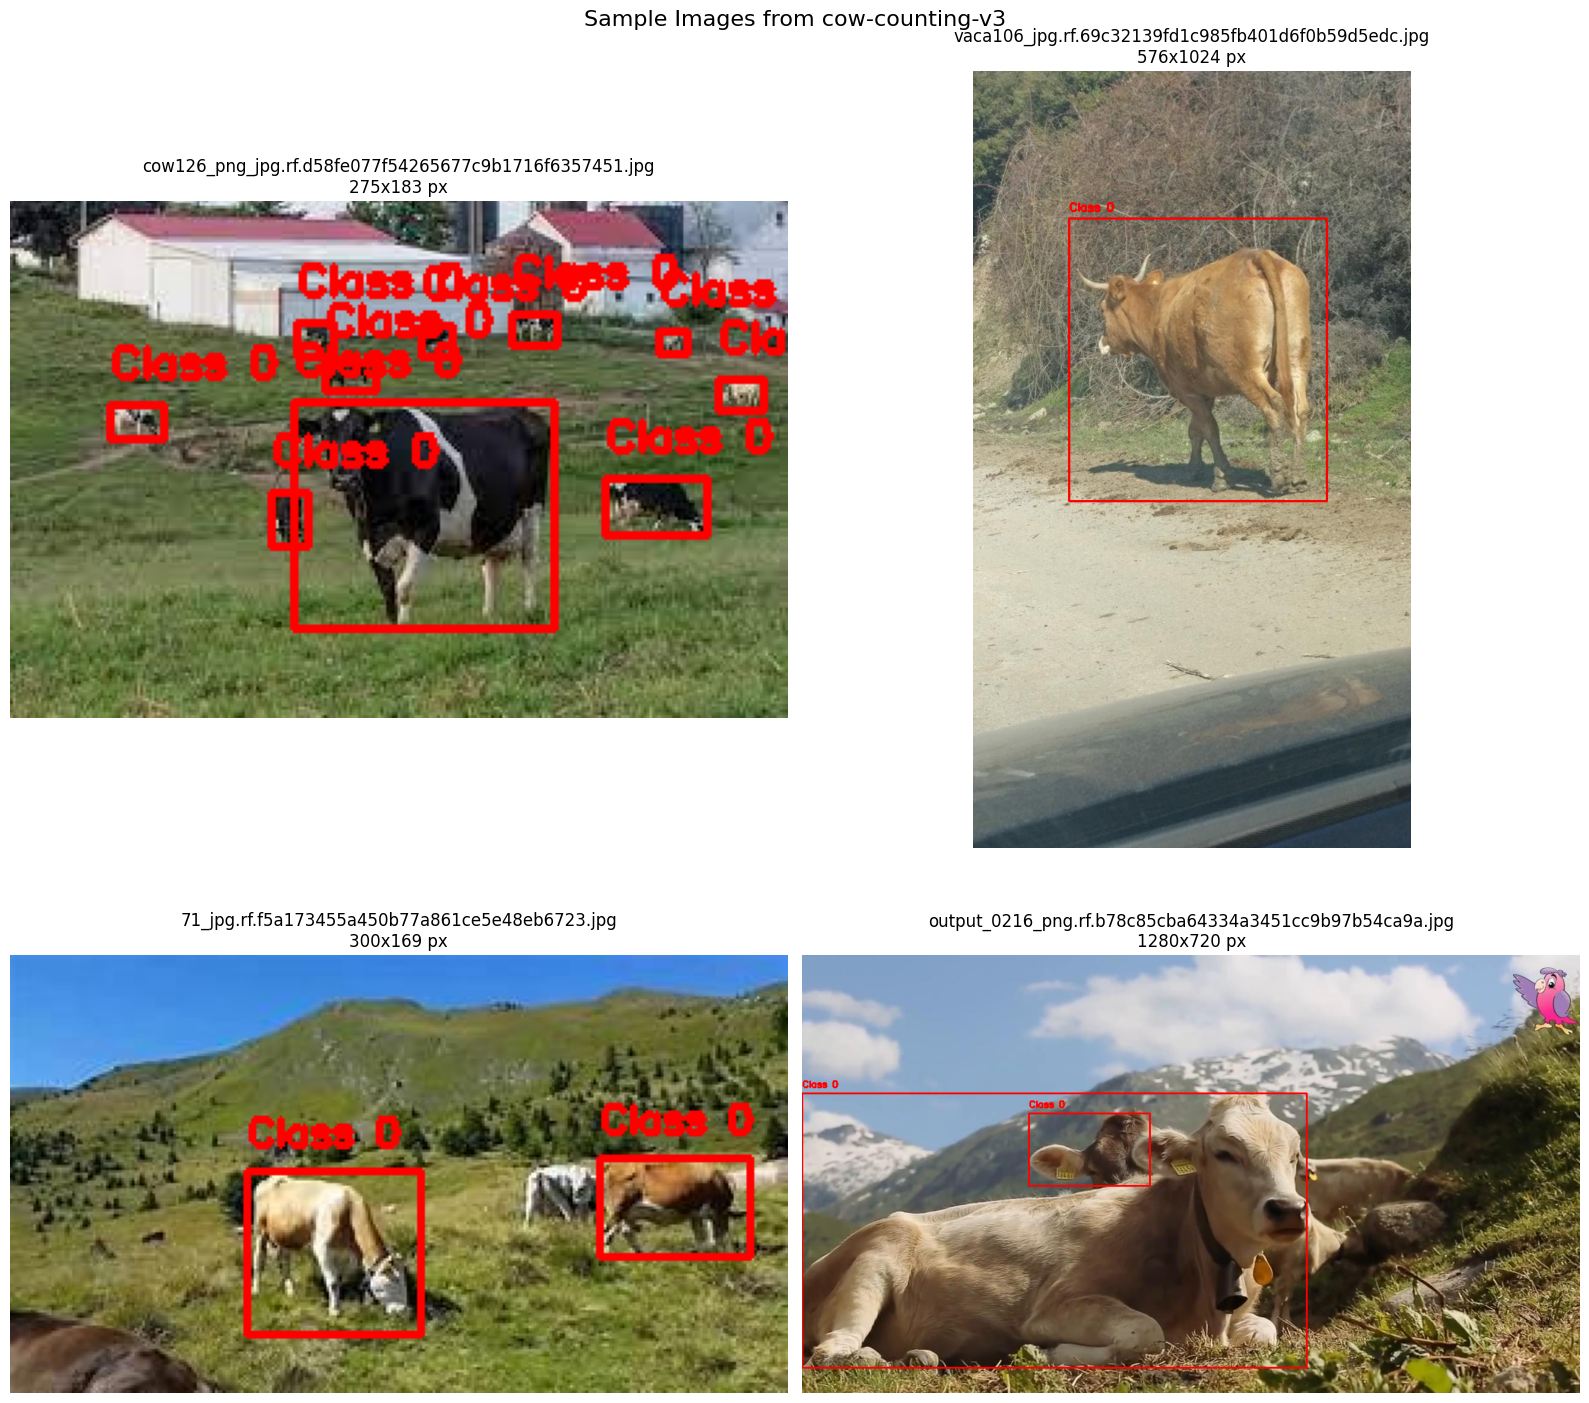

In [21]:
def visualize_sample_images(dataset_path, num_samples=4):
    """Visualize sample images with their annotations."""
    images_path = dataset_path / 'train' / 'images'
    labels_path = dataset_path / 'train' / 'labels'
    
    if not (images_path.exists() and labels_path.exists()):
        print(f"Could not find images or labels for {dataset_path.name}")
        return
    
    image_files = list(images_path.glob('*.[jp][pn]g')) + list(images_path.glob('*.jpeg'))
    
    if len(image_files) == 0:
        print(f"No images found in {dataset_path.name}")
        return
    
    # Select random samples
    samples = np.random.choice(image_files, min(num_samples, len(image_files)), replace=False)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 16))
    fig.suptitle(f'Sample Images from {dataset_path.name}', fontsize=16)
    axes = axes.flatten()
    
    for i, img_file in enumerate(samples):
        if i >= 4:  # Only show 4 samples
            break
            
        # Load image
        img = cv2.imread(str(img_file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        height, width = img.shape[:2]
        
        # Load corresponding annotation
        label_file = labels_path / (img_file.stem + '.txt')
        
        if label_file.exists():
            with open(label_file, 'r') as f:
                annotations = f.readlines()
            
            # Draw bounding boxes
            for annotation in annotations:
                parts = annotation.strip().split()
                if len(parts) >= 5:
                    class_id = int(parts[0])
                    x_center = float(parts[1]) * width
                    y_center = float(parts[2]) * height
                    bbox_width = float(parts[3]) * width
                    bbox_height = float(parts[4]) * height
                    
                    # Convert to corner coordinates
                    x1 = int(x_center - bbox_width/2)
                    y1 = int(y_center - bbox_height/2)
                    x2 = int(x_center + bbox_width/2)
                    y2 = int(y_center + bbox_height/2)
                    
                    # Draw rectangle
                    cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
                    cv2.putText(img, f'Class {class_id}', (x1, y1-10), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
        
        axes[i].imshow(img)
        axes[i].set_title(f'{img_file.name}\n{width}x{height} px')
        axes[i].axis('off')
    
    # Hide unused subplots
    for i in range(len(samples), 4):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize samples from each dataset
for dataset_path in datasets[:2]:  # Show samples from first 2 datasets to avoid too many plots
    visualize_sample_images(dataset_path)

## Summary and Recommendations

In [22]:
# Generate comprehensive summary
print("="*70)
print("CATTLE DETECTION DATASET ANALYSIS SUMMARY")
print("="*70)

total_images = sum([analysis['total_images'] for analysis in dataset_analyses])
total_annotations = sum([analysis['total_annotations'] for analysis in dataset_analyses])

print(f"\n📊 OVERALL STATISTICS:")
print(f"   • Total datasets: {len(dataset_analyses)}")
print(f"   • Total images: {total_images:,}")
print(f"   • Total annotations: {total_annotations:,}")

if image_properties:
    all_widths = [w for props in image_properties.values() for w in props['widths']]
    all_heights = [h for props in image_properties.values() for h in props['heights']]
    all_aspects = [ar for props in image_properties.values() for ar in props['aspect_ratios']]
    
    print(f"\n🖼️  IMAGE PROPERTIES:")
    print(f"   • Width range: {min(all_widths)} - {max(all_widths)} pixels")
    print(f"   • Height range: {min(all_heights)} - {max(all_heights)} pixels")
    print(f"   • Most common aspect ratio: {np.median(all_aspects):.2f}")

if annotation_stats:
    all_objects = [obj for stats in annotation_stats.values() for obj in stats['objects_per_image']]
    all_areas = [area for stats in annotation_stats.values() for area in stats['bbox_areas']]
    
    print(f"\n🎯 ANNOTATION STATISTICS:")
    print(f"   • Average objects per image: {np.mean(all_objects):.1f}")
    print(f"   • Max objects in single image: {max(all_objects)}")
    print(f"   • Average bounding box area: {np.mean(all_areas):.3f} (normalized)")

print(f"\n✅ RECOMMENDATIONS FOR PHASE 1.1:")
print(f"   1. Data Quality: All datasets appear to have proper YOLO format")
print(f"   2. Image Diversity: Multiple datasets provide good variety")
print(f"   3. Resolution: Images have varying resolutions - consider standardization")
print(f"   4. Class Balance: Review class distribution for potential imbalances")
print(f"   5. Next Steps: Ready to proceed with model training preparation")

print(f"\n🚀 READY FOR PHASE 2: Detection Model Training")
print(f"   • Dataset preparation: ✅ Complete")
print(f"   • Data analysis: ✅ Complete")
print(f"   • Visualization: ✅ Complete")
print(f"   • Next: Configure YOLO training pipeline")

print("\n" + "="*70)

CATTLE DETECTION DATASET ANALYSIS SUMMARY

📊 OVERALL STATISTICS:
   • Total datasets: 4
   • Total images: 7,721
   • Total annotations: 7,721

🖼️  IMAGE PROPERTIES:
   • Width range: 183 - 1920 pixels
   • Height range: 168 - 1099 pixels
   • Most common aspect ratio: 1.00

🎯 ANNOTATION STATISTICS:
   • Average objects per image: 14.3
   • Max objects in single image: 158
   • Average bounding box area: 0.009 (normalized)

✅ RECOMMENDATIONS FOR PHASE 1.1:
   1. Data Quality: All datasets appear to have proper YOLO format
   2. Image Diversity: Multiple datasets provide good variety
   3. Resolution: Images have varying resolutions - consider standardization
   4. Class Balance: Review class distribution for potential imbalances
   5. Next Steps: Ready to proceed with model training preparation

🚀 READY FOR PHASE 2: Detection Model Training
   • Dataset preparation: ✅ Complete
   • Data analysis: ✅ Complete
   • Visualization: ✅ Complete
   • Next: Configure YOLO training pipeline



In [24]:
# Save analysis results
import json

# Prepare data for saving (convert numpy types to native Python types)
def convert_numpy_types(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: convert_numpy_types(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_types(item) for item in obj]
    else:
        return obj

# Create summary report
analysis_report = {
    'timestamp': pd.Timestamp.now().isoformat(),
    'dataset_analyses': convert_numpy_types(dataset_analyses),
    'image_properties_summary': {},
    'annotation_stats_summary': {},
    'total_statistics': {
        'total_datasets': len(dataset_analyses),
        'total_images': total_images,
        'total_annotations': total_annotations
    }
}

# Add image properties summary
if image_properties:
    for dataset_name, props in image_properties.items():
        analysis_report['image_properties_summary'][dataset_name] = {
            'sample_size': len(props['widths']),
            'avg_width': float(np.mean(props['widths'])),
            'avg_height': float(np.mean(props['heights'])),
            'avg_aspect_ratio': float(np.mean(props['aspect_ratios'])),
            'avg_file_size_mb': float(np.mean(props['file_sizes']))
        }

# Add annotation stats summary
if annotation_stats:
    for dataset_name, stats in annotation_stats.items():
        analysis_report['annotation_stats_summary'][dataset_name] = {
            'sample_size': len(stats['objects_per_image']),
            'avg_objects_per_image': float(np.mean(stats['objects_per_image'])),
            'total_objects': int(sum(stats['objects_per_image'])),
            'class_distribution': convert_numpy_types(dict(stats['class_distribution'])),
            'avg_bbox_area': float(np.mean(stats['bbox_areas']))
        }

# Save to file
output_file = PROJECT_ROOT / 'data' / 'dataset_analysis_report.json'
output_file.parent.mkdir(parents=True, exist_ok=True)

with open(output_file, 'w') as f:
    json.dump(analysis_report, f, indent=2)

print(f"Analysis report saved to: {output_file}")
print(f"Report contains {len(analysis_report)} main sections")
print("This report can be used for:")
print("  • Model training configuration")
print("  • Data preprocessing decisions")
print("  • Performance benchmarking")
print("  • Documentation and reporting")

Analysis report saved to: /home/nicolas-ubuntu/Desktop/repos/cattle/cattle-recognition/data/dataset_analysis_report.json
Report contains 5 main sections
This report can be used for:
  • Model training configuration
  • Data preprocessing decisions
  • Performance benchmarking
  • Documentation and reporting
